In [1]:
import os
import sys

sys.path.append(os.path.join(".."))

import os

import numpy as np
import torch

from src.evaluation import load_data_from_files
from src.model_utils import custom_multiclass_report
import pickle
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
from src.model_utils import (
    CropLSTM,
    CropMLP,
    CropConvLSTM,
    CropTransformer,
    CropPL,
    custom_multiclass_report,
)
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from catboost import CatBoostClassifier


##  Data

In [2]:
data = load_data_from_files()
X_lstm, X, y, keys = data["X_lstm"], data["X"], data["y"], data["keys"]

del data

## Testing models on the same test data

In [6]:
# Path to pickled models
path_to_pickled_models = os.path.join("..", "results", "pickle_models")

clf_dict = {
    "lr": os.path.join(path_to_pickled_models, "Logistic_Regression.pkl"),
    "lgbm": os.path.join(path_to_pickled_models, "LightGBM.pkl"),
    "xgboost": os.path.join(path_to_pickled_models, "XGBoost.pkl"),
    "catboost": os.path.join(path_to_pickled_models, "catboost.pkl"),
}

clf_nn_dict = {
    "mlp": os.path.join(path_to_pickled_models, "MLP.ckpt"),
    "lstm": os.path.join(path_to_pickled_models, "LSTM.ckpt"),
    "transformer": os.path.join(path_to_pickled_models, "transformer.ckpt"),
    "convlstm": os.path.join(path_to_pickled_models, "conv_lstm.ckpt")
}

### Calculate metrics for all models in a sequence

In [7]:
models_dict = {**clf_dict, **clf_nn_dict}


In [8]:
y_probs = {}
softmax = nn.Softmax(dim=1)
trainer = pl.Trainer(accelerator="gpu", devices=[3])

for model in tqdm(models_dict):
    if model in ["mlp", "lstm", "transformer", "convlstm"]:
        if model == "mlp":
            network = CropMLP()
        elif model == "lstm":
            network = CropLSTM()
        elif model == "transformer":
            network = CropTransformer()
        elif model == "convlstm":
            network = CropConvLSTM()

        checkpoint = torch.load(models_dict[model])
        loaded_model = CropPL(net=network)
        loaded_model.load_state_dict(checkpoint["state_dict"])
        loaded_model.eval()

        # Use appropriate input tensor for the model
        input_tensor = (
            X_lstm if model in ["lstm", "transformer", "convlstm"] else X
        )
        for key, value in input_tensor.items():
            input = torch.tensor(value, dtype=torch.float)
            predictions = torch.cat(
                trainer.predict(
                    loaded_model, DataLoader(input, batch_size=2048)
                ),
                dim=0,
            )
            y_prob = softmax(predictions.float()).numpy()
            y_probs[f'{model}_{key}'] = y_prob
            # np.save(f'../results/2000_2010/{model}_{key}_probs.npy', y_prob)
    elif model == "catboost":
        loaded_model = CatBoostClassifier()
        loaded_model.load_model(clf_dict[model])
        for key, value in X.items():
            y_prob = loaded_model.predict_proba(value)
            y_probs[f'{model}_{key}'] = y_prob
    else:
        loaded_model = pickle.load(open(models_dict[model], "rb"))
        for key, value in X.items():
            y_prob = loaded_model.predict_proba(value)
            y_probs[f'{model}_{key}'] = y_prob
            # np.save(f'../results/2000_2010/{model}_{key}_probs.npy', y_prob)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [09:18<10:57, 164.30s/it]You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

 62%|██████▎   | 5/8 [09:50<05:49, 116.46s/it]You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

 75%|███████▌  | 6/8 [10:48<03:13, 96.70s/it] You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

 88%|████████▊ | 7/8 [11:25<01:17, 77.23s/it]You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

100%|██████████| 8/8 [12:19<00:00, 92.42s/it]


In [9]:
X_train = pd.DataFrame()
X_val = pd.DataFrame()   
X_test = pd.DataFrame()
for key, value in y_probs.items():
    model, st = tuple(key.split('_'))
    if st == "Train":
        X_train = pd.concat([X_train,pd.DataFrame(value, columns=[f"{model}_prob_class{i}" for i in range(value.shape[1])])],axis=1)
    elif st == "Val":
        X_val = pd.concat([X_val,pd.DataFrame(value, columns=[f"{model}_prob_class{i}" for i in range(value.shape[1])])],axis=1)
    elif st == "Test":
        X_test= pd.concat([X_test,pd.DataFrame(value, columns=[f"{model}_prob_class{i}" for i in range(value.shape[1])])],axis=1)
    

In [10]:
y_train, y_val, y_test = np.argmax(y['Train'],axis=1), np.argmax(y['Val'],axis=1), np.argmax(y['Test'],axis=1)

In [11]:
X_meta = dict()

X_meta["Train"] = X_train
X_meta["Val"] = X_val
X_meta["Test"] = X_test 

In [12]:
with open(
    os.path.join("..", "data", "processed_files", "pkls", "X_meta.pkl"), "wb"
) as fp:
    pickle.dump(X_meta, fp)

In [13]:
model = CatBoostClassifier(eval_metric= "TotalF1", verbose=True)
    
model.fit(
    X_train,
    y_train,    
    eval_set=[(X_val, y_val)],
    verbose=0,
    early_stopping_rounds=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93   2493115
           1       0.66      0.58      0.62     31174
           2       0.41      0.72      0.52    124554
           3       0.48      0.87      0.61    249306

    accuracy                           0.86   2898149
   macro avg       0.63      0.76      0.67   2898149
weighted avg       0.92      0.86      0.88   2898149



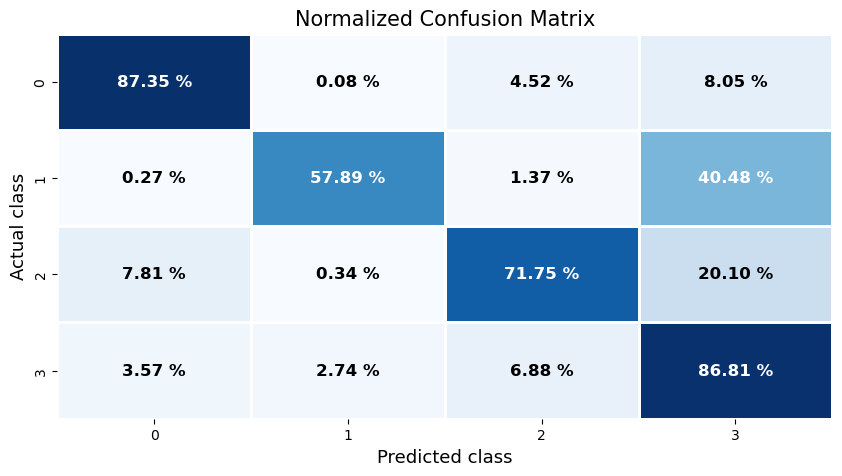

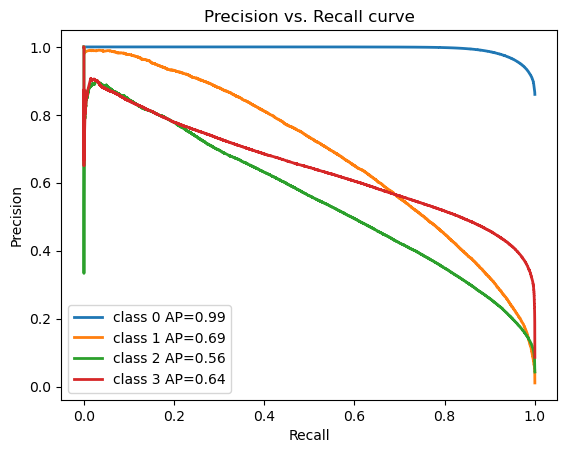

Average AP over all classes: 0.7206


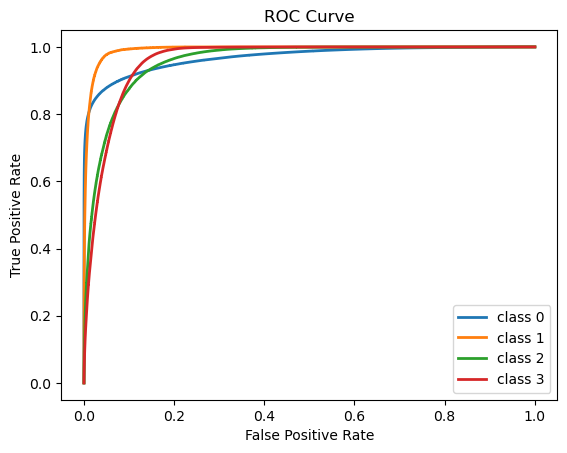

0 ROC AUC OVR: 0.9689
1 ROC AUC OVR: 0.9923
2 ROC AUC OVR: 0.9579
3 ROC AUC OVR: 0.9595
Average ROC AUC OVR: 0.9697


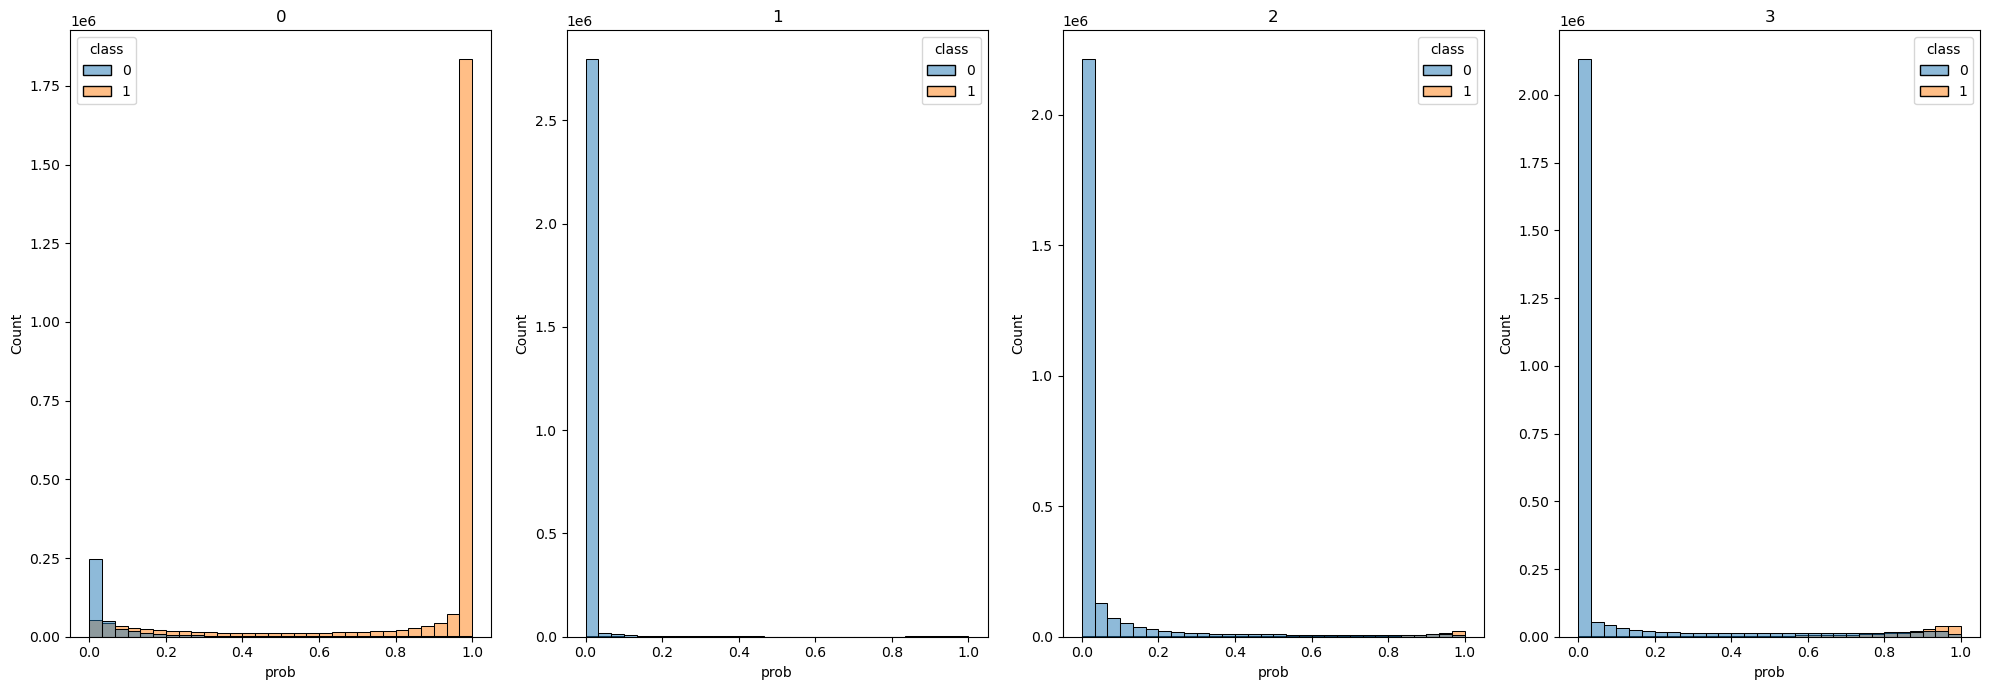

0 vs 1 ROC AUC OVO: 0.9938
0 vs 2 ROC AUC OVO: 0.9603
0 vs 3 ROC AUC OVO: 0.9701
1 vs 2 ROC AUC OVO: 0.9878
1 vs 3 ROC AUC OVO: 0.9419
2 vs 3 ROC AUC OVO: 0.9258
Average ROC AUC OVO: 0.9633


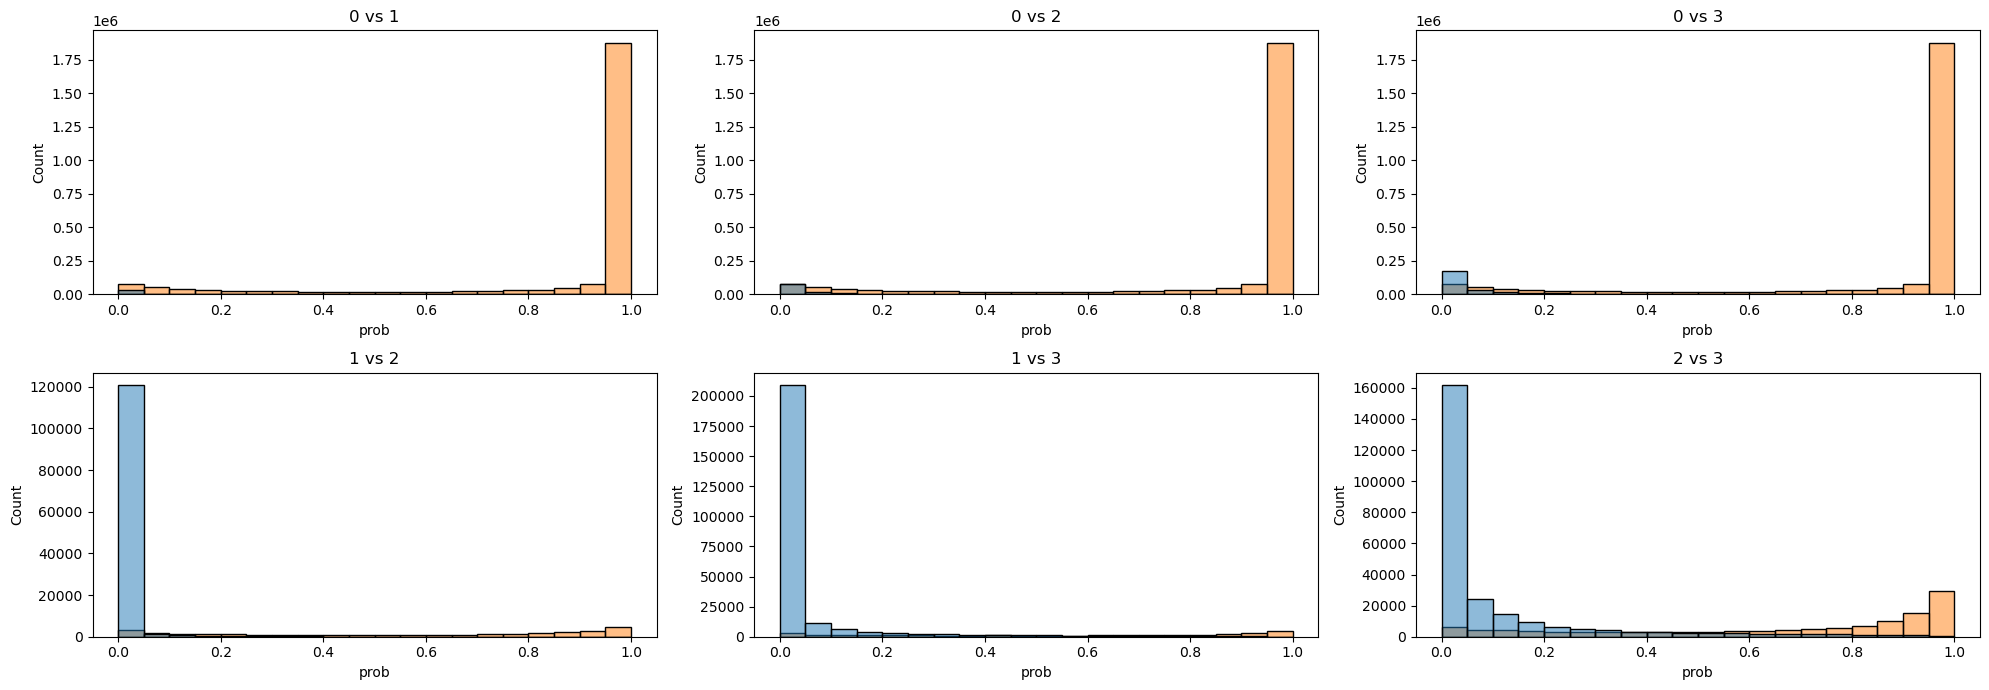

In [14]:
y_prob = model.predict_proba(X_test)
custom_multiclass_report(y_test, np.argmax(y_prob, axis=1), y_prob)

In [15]:
# Save the trained model to a file
model_filename = os.path.join("..", "results", "pickle_models", "meta_catboost.pkl")
model.save_model(model_filename)
print("Model saved as:", model_filename)

Model saved as: ../results/pickle_models/meta_catboost.pkl
